# Master BigData UCM 2023

## AGRADECIMIENTOS

Este script está basado en el trabajo de Diva Flores, alumna de la clase 2 del máster. Quiero agradecerla aquí el gran trabajo que realizó para localizar los datos de población y su pre-proceso, que no es trivial, como veréis



# Visualización Avanzada
En el presente trabajo se analizarán los datos de COVID-19 que se obtienen a partir de la declaración de los casos a la Red Nacional de Vigilancia Epidemiológica (RENAVE) a través de la plataforma informática vía Web SiViES (Sistema de Vigilancia de España) que gestiona el Centro Nacional de Epidemiología (CNE). Estos datos corresponden al periodo comprendido entre el inicio de la pandemia (enero-2020) hasta el 28 de marzo de 2022.

Para realizar algunos cálculos más específicos utilizaremos datos del INE, específicamente de población por provincia y franja etaria de los últimos tres años (2020, 2021 y 2022) y los datos de polígonos que correspoden a las representaciones gráficas de las provincias de España.

**Para empezar, importamos las librerías que utilizaremos para este análisis.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from datetime import date
from datetime import datetime
import plotly.express as px
import plotnine
from plotnine import *
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
import folium

### Lectura de datasets
Realizamos la lectura de los datasets de Covid y provincias (previamente descargados) y realizamos unos primeros ajustes a los mismos.

Los archivos se encuentran en el mismo directorio del presente notebook.

In [2]:
covid = pd.read_csv(r'casos_hosp_uci_def_sexo_edad_provres.csv')
prv = pd.read_csv(r'provinces_es.csv')
# geo_prv = r'SP_provincias.geojson'


**Realizamos una pre-visualización del contenido**

In [3]:
covid.head()

,provincia_iso,sexo,grupo_edad,fecha,num_casos,num_hosp,num_uci,num_def
0,A,H,0-9,2020-01-01,0,0,0,0
1,A,H,10-19,2020-01-01,0,0,0,0
2,A,H,20-29,2020-01-01,0,0,0,0
3,A,H,30-39,2020-01-01,0,0,0,0
4,A,H,40-49,2020-01-01,0,0,0,0


In [4]:
prv.head()

,code,postal_code,name,phone_code,iso2
0,VI,1,Álava,945,ES
1,AB,2,Albacete,967,ES
2,A,3,Alacant,950,ES
3,AL,4,Almería,920,ES
4,AV,5,Ávila,924,ES


**Empezamos uniendo nuestros datasets de covid y provincias**

In [5]:
cov_prv = covid.merge(prv, 
                      how='left', 
                      left_on='provincia_iso', 
                      right_on='code', 
                      suffixes=('_cov', '_prv'))

**Realizamos algunos formateos a los datos, para que nos ayuden en las visualizaciones posteriores**

In [6]:
cov_prv['periodo'] = cov_prv['fecha'].str.slice(0, 4)
cov_prv['periodo'] = pd.to_numeric(cov_prv['periodo'])
cov_prv['fecha'] = pd.to_datetime(covid['fecha'], 
                                  format = '%Y-%m-%d', 
                                  errors = 'coerce')
cov_prv['semana'] = cov_prv['fecha'].dt.week

cov_prv.drop(['name', 'phone_code', 'iso2'], 
             axis = 'columns', 
             inplace=True)
cov_prv.rename(columns={'grupo_edad': 'franja_etaria'}, 
               inplace=True)
cov_prv.head()

,provincia_iso,sexo,franja_etaria,fecha,num_casos,num_hosp,num_uci,num_def,code,postal_code,periodo,semana
0,A,H,0-9,2020-01-01,0,0,0,0,A,3.0,2020,1
1,A,H,10-19,2020-01-01,0,0,0,0,A,3.0,2020,1
2,A,H,20-29,2020-01-01,0,0,0,0,A,3.0,2020,1
3,A,H,30-39,2020-01-01,0,0,0,0,A,3.0,2020,1
4,A,H,40-49,2020-01-01,0,0,0,0,A,3.0,2020,1


**Realizamos la importación de los datos de población de cada provincia, correspondientes a los años 2020, 2021 y 2022.**

**Luego, unimos las tres fuentes en un único dataset.**

In [7]:
pob_esp2020 = pd.read_csv(r'PoblacionEspana-Provincia_2020.csv',
                          sep=';',
                          encoding='latin-1'
                          ,
                          decimal = ',',
                          thousands = '.'
                         )


In [8]:
pob_esp2020.head()

,Edad Simple,Provincias,Sexo,Periodo,Total
0,0 años,02 Albacete,Hombres,1 de julio de 2020,1475.5
1,0 años,02 Albacete,Mujeres,1 de julio de 2020,1352.5
2,0 años,03 Alicante/Alacant,Hombres,1 de julio de 2020,6962.0
3,0 años,03 Alicante/Alacant,Mujeres,1 de julio de 2020,6641.0
4,0 años,04 Almería,Hombres,1 de julio de 2020,3568.5


In [9]:
pob_esp2020.describe(include = 'all')

,Edad Simple,Provincias,Sexo,Periodo,Total
count,10504,10504,10504,10504,10504.000000
unique,101,52,2,1,NaN
top,0 años,02 Albacete,Hombres,1 de julio de 2020,NaN
freq,104,202,5252,10504,NaN
mean,NaN,NaN,NaN,NaN,4508.347732
std,NaN,NaN,NaN,NaN,6815.777133
min,NaN,NaN,NaN,NaN,0.756743
25%,NaN,NaN,NaN,NaN,1061.426210
50%,NaN,NaN,NaN,NaN,2574.354729
75%,NaN,NaN,NaN,NaN,5043.655903


In [10]:
pob_esp2021 = pd.read_csv(r'PoblacionEspana-Provincia_2021.csv',
                          sep=';',
                          encoding='latin-1'
                          ,
                          decimal = ',',
                          thousands = '.'
                         )


In [11]:
pob_esp2022 = pd.read_csv(r'PoblacionEspana-Provincia_2022.csv',
                          sep=';',
                          encoding='latin-1'
                          ,
                          decimal = ',',
                          thousands = '.'
                         )


In [12]:
pob_esp = pd.concat([pob_esp2020, pob_esp2021, pob_esp2022])
pob_esp.head(3)

,Edad Simple,Provincias,Sexo,Periodo,Total
0,0 años,02 Albacete,Hombres,1 de julio de 2020,1475.5
1,0 años,02 Albacete,Mujeres,1 de julio de 2020,1352.5
2,0 años,03 Alicante/Alacant,Hombres,1 de julio de 2020,6962.0


**A continuación, realizamos algunos formateos al dataset para dejarlo a punto para el análisis**

In [13]:
pob_esp.rename(columns={'Edad Simple': 'edad', 
                        'Provincias': 'provincia', 
                        'Sexo':'sexo', 
                        'Periodo':'periodo', 
                        'Total':'total'}, 
               inplace=True)

In [15]:
pob_esp['postal_code'] = pob_esp['provincia'].str.slice(0, 2)
pob_esp['postal_code'] = pd.to_numeric(pob_esp['postal_code'])

In [16]:
pob_esp.loc[pob_esp['sexo'] == 'Hombres', 'sexo'] = 'H'
pob_esp.loc[pob_esp['sexo'] == 'Mujeres', 'sexo'] = 'M'

In [17]:
datos = pob_esp['edad'].str.split(expand=True)
datos.columns = ['edad2', 'edad3', 'edad4', 'edad5']
pob_esp = pd.concat([pob_esp, datos], axis=1)
pob_esp.drop(['edad3', 'edad4', 'edad5'], 
             axis = 'columns', 
             inplace=True)
pob_esp['edad2'] = pd.to_numeric(pob_esp['edad2'])
pob_esp.head(3)

,edad,provincia,sexo,periodo,total,postal_code,edad2
0,0 años,02 Albacete,H,1 de julio de 2020,1475.5,2,0
1,0 años,02 Albacete,M,1 de julio de 2020,1352.5,2,0
2,0 años,03 Alicante/Alacant,H,1 de julio de 2020,6962.0,3,0


In [18]:
def franja_etaria(edad):
    if edad < 10:
        franja = '0-9'
    elif edad < 20:
        franja = '10-19'
    elif edad < 30:
        franja = '20-29'
    elif edad < 40:
        franja = '30-39'
    elif edad < 50:
        franja = '40-49'
    elif edad < 60:
        franja = '50-59'
    elif edad < 70:
        franja = '60-69'
    elif edad < 80:
        franja = '70-79'
    else:
        franja = '80+'
    return franja

In [19]:
pob_esp['franja_etaria'] = pob_esp['edad2'].apply(franja_etaria)

In [20]:
separado = pob_esp['periodo'].str.split(' ', expand=True)
pob_esp['periodo']= separado[4]
pob_esp['periodo'] = pd.to_numeric(pob_esp['periodo'])
pob_esp.head(3)

,edad,provincia,sexo,periodo,total,postal_code,edad2,franja_etaria
0,0 años,02 Albacete,H,2020,1475.5,2,0,0-9
1,0 años,02 Albacete,M,2020,1352.5,2,0,0-9
2,0 años,03 Alicante/Alacant,H,2020,6962.0,3,0,0-9


**A continuación, agrupamos los datos de poblacion por año y provincia, para cruzarlo con nuestro dataset de casos de Covid.**

In [21]:
poblacion = pob_esp.groupby(['periodo', 
                             'provincia', 
                             'postal_code', 
                            ]).agg({'total':'sum'}).reset_index()
poblacion.head()

,periodo,provincia,postal_code,total
0,2020,01 Araba/Álava,1,3.301570e+05
1,2020,02 Albacete,2,3.890275e+05
2,2020,03 Alicante/Alacant,3,1.889768e+06
3,2020,04 Almería,4,7.171430e+05
4,2020,05 Ávila,5,1.580949e+05


### Incidencia Acumulada a 14 días por cada 100.000 habitantes
Calculamos la IA a 14 días por cada cien mil habitantes.

In [22]:
sum_cov = cov_prv.groupby(['fecha', 'periodo']).agg({'num_casos':'sum'})

In [23]:
sum_cov.describe(include = 'all')

,num_casos
count,817.000000
mean,14176.920441
std,26005.156069
min,0.000000
25%,2063.000000
50%,6145.000000
75%,14057.000000
max,176361.000000


In [24]:
def buildLaggedFeatures(s, lag=2, dropna=True):
    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            for l in range(1,lag+1):
                new_dict['%s_%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['_%d' %i for i in the_range]
    else:
        print ('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res

In [25]:
casos_trend = buildLaggedFeatures(sum_cov,lag=13,dropna=False)

In [26]:
casos_trend = casos_trend.reset_index()

In [27]:
casos_trend2 = pd.melt(casos_trend, 
                       id_vars=['fecha', 'periodo'], 
                       value_vars=['num_casos', 'num_casos_1', 'num_casos_2','num_casos_3', 'num_casos_4', 
                                   'num_casos_5', 'num_casos_6', 'num_casos_7', 'num_casos_8', 'num_casos_9', 
                                   'num_casos_10', 'num_casos_11', 'num_casos_12', 'num_casos_13'])

In [28]:
casos_trend2 = casos_trend2.groupby(['fecha', 'periodo']).agg({'value':'sum'}).reset_index()
pob = poblacion.groupby(['periodo']).agg({'total':'sum'}).reset_index()
casos_trend_pob = casos_trend2.merge(pob, how='left', left_on='periodo', right_on='periodo')
casos_trend_pob['ia14d'] = casos_trend_pob['value']/casos_trend_pob['total']*100000
casos_trend_pob.head()

,fecha,periodo,value,total,ia14d
0,2020-01-01,2020,0.0,4.735568e+07,0.0
1,2020-01-02,2020,0.0,4.735568e+07,0.0
2,2020-01-03,2020,0.0,4.735568e+07,0.0
3,2020-01-04,2020,0.0,4.735568e+07,0.0
4,2020-01-05,2020,0.0,4.735568e+07,0.0


**Visualizamos la tendencia de la IA**

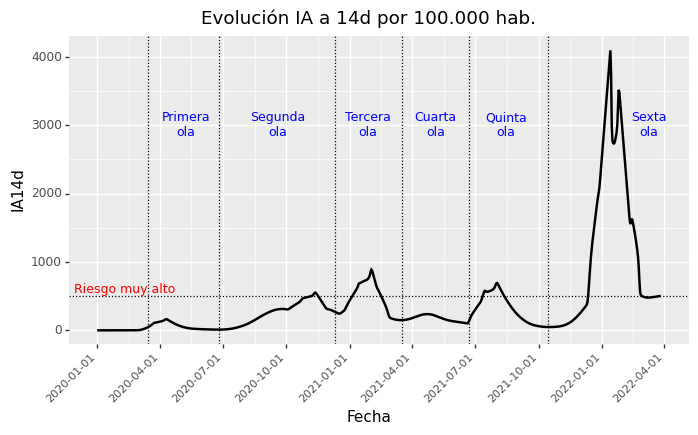

<ggplot: (8749898594235)>

In [29]:
(
    ggplot(casos_trend_pob)  
    + aes(x = 'fecha', 
          y = 'ia14d')   
    #+ geom_rect(data=df, mapping=aes(xmin=df.x1, xmax=df.x2, ymin=0, ymax=80000, fill=df.r), color="black", alpha=0.5)
    + geom_smooth(method = "lowess", 
                  span = 0.05)

    #+ geom_hline(yintercept = 500, size = 0.5, linetype = 'dotted')
    + geom_hline(yintercept = 500, size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2020-03-15', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2020-06-25', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2020-12-10', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2021-03-17', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2021-06-23', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2021-10-14', size = 0.5, linetype = 'dotted')
    + theme(figure_size=(8, 4),
            axis_text_x = element_text(angle = 45,
                                      hjust = 1,
                                      size = 8))
    + annotate('text', x='2020-02-10', y=600, label='Riesgo muy alto', size=9, color='red')
    + annotate('text', x='2020-05-08', y=3000, label='Primera\nola', size=9, color='blue')
    + annotate('text', x='2020-09-18', y=3000, label='Segunda\nola', size=9, color='blue')
    + annotate('text', x='2021-01-27', y=3000, label='Tercera\nola', size=9, color='blue')
    + annotate('text', x='2021-05-05', y=3000, label='Cuarta\nola', size=9, color='blue')
    + annotate('text', x='2021-08-15', y=3000, label='Quinta\nola', size=9, color='blue')
    + annotate('text', x='2022-03-10', y=3000, label='Sexta\nola', size=9, color='blue')
    + labs(title='Evolución IA a 14d por 100.000 hab.', x='Fecha', y='IA14d')
)


Se visualizan picos en determinados momentos de la pandemia, que corresponden a las diferentes olas, notándose especialmente la correspondiente a la sexta ola de la pandemia.

## población de cada franja etaria

**A continuación, realizamos algunos formateos al dataset para dejarlo a punto para el análisis**

In [30]:
pob_esp.rename(columns={'Edad Simple': 'edad', 
                        'Provincias': 'provincia', 
                        'Sexo':'sexo', 
                        'Periodo':'periodo', 
                        'Total':'total'}, 
               inplace=True)

In [31]:
pob_esp['postal_code'] = pob_esp['provincia'].str.slice(0, 2)
pob_esp['postal_code'] = pd.to_numeric(pob_esp['postal_code'])

In [32]:
pob_esp.loc[pob_esp['sexo'] == 'Hombres', 'sexo'] = 'H'
pob_esp.loc[pob_esp['sexo'] == 'Mujeres', 'sexo'] = 'M'

In [35]:
pob_esp.head()

,edad,provincia,sexo,periodo,total,postal_code,edad2,franja_etaria,edad2
0,0 años,02 Albacete,H,2020,1475.5,2,0,0-9,0
1,0 años,02 Albacete,M,2020,1352.5,2,0,0-9,0
2,0 años,03 Alicante/Alacant,H,2020,6962.0,3,0,0-9,0
3,0 años,03 Alicante/Alacant,M,2020,6641.0,3,0,0-9,0
4,0 años,04 Almería,H,2020,3568.5,4,0,0-9,0


In [36]:
datos = pob_esp['edad'].str.split(expand=True)
datos

,0,1,2,3
0,0,años,None,None
1,0,años,None,None
2,0,años,None,None
3,0,años,None,None
4,0,años,None,None
...,...,...,...,...
10499,100,y,más,años
10500,100,y,más,años
10501,100,y,más,años
10502,100,y,más,años


In [39]:
datos.columns = ['edad2', 'edad3', 'edad4', 'edad5']
datos.describe()

,edad2,edad3,edad4,edad5
count,31512,31512,312,312
unique,101,3,1,1
top,0,años,más,años
freq,312,30888,312,312


In [45]:
print(datos.dtypes)

edad2    object
edad3    object
edad4    object
edad5    object
dtype: object


In [46]:
print(datos['edad2'].to_list())


['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',

In [47]:
pob_esp = pd.concat([pob_esp, datos], axis=1)
pob_esp.drop(['edad3', 'edad4', 'edad5'], axis = 'columns', inplace=True)


In [48]:
edades = datos['edad2'].to_list()

In [49]:
pob_esp['edad2'] = pd.to_numeric(edades)
pob_esp.head(3)

,edad,provincia,sexo,periodo,total,postal_code,edad2,franja_etaria,edad2,edad2,edad2
0,0 años,02 Albacete,H,2020,1475.5,2,0,0-9,0,0,0
1,0 años,02 Albacete,M,2020,1352.5,2,0,0-9,0,0,0
2,0 años,03 Alicante/Alacant,H,2020,6962.0,3,0,0-9,0,0,0


In [ ]:
pob_periodo_franja = pob_esp.groupby(['periodo','franja_etaria']).agg({'total':'sum'}).reset_index()

In [ ]:
pob_periodo_franja = pob_esp.groupby([' 
                        'Provincias': 'provincia', 
                        'Sexo':'sexo', 
                        'Periodo':'periodo', 
                        'Total':'total'}, 
               inplace=True)eriodo','franja_etaria']).agg({'total':'sum'}).reset_index()

In [ ]:
casos_franja_periodo = cov_prv.groupby(['periodo', 
                                     'franja_etaria']).agg({'num_casos':'sum',
                                                   'num_hosp':'sum', 
                                                   'num_uci':'sum', 
                                                   'num_def':'sum'
                                                  }).reset_index()

In [ ]:
casos_franja_periodo = casos_franja_periodo.merge(pob_periodo_franja, 
                                            how='left', 
                                            left_on=['periodo', 'franja_etaria'], 
                                            right_on=['periodo', 'franja_etaria'])

In [ ]:
casos_franja_periodo = casos_franja_periodo.groupby(['franja_etaria']).agg({'num_casos':'sum', 
                                                               'num_hosp':'sum', 
                                                               'num_uci':'sum', 
                                                               'num_def':'sum', 
                                                               'total':'mean'
                                                              }).reset_index()

In [ ]:
casos_franja_periodo.rename(columns={'total':'poblacion'}, inplace=True)

In [ ]:
casos_franja_periodo = casos_franja_periodo[casos_franja_periodo['franja_etaria']!='NC']
casos_franja_periodo['ratio_casos'] = casos_franja_periodo['num_casos']/casos_franja_periodo['poblacion']
casos_franja_periodo['ratio_hospitalizado'] = casos_franja_periodo['num_hosp']/casos_franja_periodo['num_casos']
casos_franja_periodo['ratio_uci'] = casos_franja_periodo['num_uci']/casos_franja_periodo['num_casos']
casos_franja_periodo['letalidad'] = casos_franja_periodo['num_def']/casos_franja_periodo['num_casos']

### Franja etaria y sexo
Hacemos el drill down por sexo para analizar si existen patrones diferentes entre hombres y mujeres

In [ ]:
pob_periodo_franja_sexo = pob_esp.groupby(['periodo',
                                           'franja_etaria', 
                                           'sexo']).agg({'total':'sum'}).reset_index()

In [ ]:
casos_franja_sexo = cov_prv.groupby(['periodo', 
                                     'franja_etaria', 
                                     'sexo']).agg({'num_casos':'sum',
                                                   'num_hosp':'sum', 
                                                   'num_uci':'sum', 
                                                   'num_def':'sum'
                                                  }).reset_index()

In [ ]:
casos_franja_sexo = casos_franja_sexo.merge(pob_periodo_franja_sexo, 
                                            how='left', 
                                            left_on=['periodo', 'franja_etaria', 'sexo'], 
                                            right_on=['periodo', 'franja_etaria', 'sexo'])

In [ ]:
casos_franja_sexo = casos_franja_sexo.groupby(['franja_etaria'
                                               , 'sexo']).agg({'num_casos':'sum', 
                                                               'num_hosp':'sum', 
                                                               'num_uci':'sum', 
                                                               'num_def':'sum', 
                                                               'total':'mean'
                                                              }).reset_index()

In [ ]:
casos_franja_sexo.rename(columns={'total':'poblacion'}, inplace=True)

In [ ]:
casos_franja_sexo = casos_franja_sexo[casos_franja_sexo['franja_etaria']!='NC']
casos_franja_sexo = casos_franja_sexo[casos_franja_sexo['sexo']!='NC']
casos_franja_sexo['ratio_casos'] = casos_franja_sexo['num_casos']/casos_franja_sexo['poblacion']
casos_franja_sexo['ratio_hospitalizado'] = casos_franja_sexo['num_hosp']/casos_franja_sexo['num_casos']
casos_franja_sexo['ratio_uci'] = casos_franja_sexo['num_uci']/casos_franja_sexo['num_casos']
casos_franja_sexo['letalidad'] = casos_franja_sexo['num_def']/casos_franja_sexo['num_casos']


**Visualizamos el acumulado de casos por franja etaria discriminado por hombres/mujeres**

In [ ]:
(
    ggplot(casos_franja_sexo)  
    + aes('franja_etaria', 
          'ratio_hospitalizado',
          fill = 'sexo')
    + geom_bar(position = "dodge",
               stat = "identity") 
    + labs(title='Ratio de hospitalizados por franja etaria', x='Franja etaria', y='Ratio')
    + theme(figure_size=(8, 4))
)


En casi todas las franjas etarias, vemos un mayor ratio de hombres hospitalizados, incrementándose a mayor edad.

In [ ]:
(
    ggplot(casos_franja_sexo)  
    + aes('franja_etaria', 
          'ratio_uci',
          fill = 'sexo')
    + geom_bar(position = "dodge",
               stat = "identity") 
    + labs(title='Ratio UCI por franja etaria', x='Franja etaria', y='Ratio')
    + theme(figure_size=(8, 4))
)

En ingreso a UCI notamos mayores ratios en hombres que en mujeres, especialmente en el rango 60-79 años.

In [ ]:
(
    ggplot(casos_franja_sexo)  
    + aes('franja_etaria', 
          'letalidad',
          fill = 'sexo')
    + geom_bar(position = 'dodge',
               stat = "identity") 
    #+ scale_y_continuous(labels='percent')
    + labs(title='Letalidad por franja etaria', x='Franja etaria', y='Letalidad (%)')
    + theme(figure_size=(8, 4))
    
)

La letalidad es evidentemente mayor en hombres que en mujeres, con un porcentaje importante, sobre todo en edades de 80 años en adelante, llegando a casi un 16%